In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
comp = 'bluebook-for-bulldozers'

In [4]:
path = URLs.path(comp)
path
Path.BASE_PATH = path

In [5]:
 from kaggle import api

# if not path.exists():
#     path.mkdir(parents=true)
#     api.competition_download_cli(comp, path=path)
#     shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

# path.ls(file_type='text')

General Embeddings nodes:
- categorical variabels can be turned into continuous in a process known as embedding

## Loading in Data

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
# Using low_memory = false to ensure less data processing errors (pandas looks over all data)

In [7]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [8]:
# Handling ordinal columns

df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [9]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var]) # to match the kaggle submission

In [11]:
df = add_datepart(df, 'saledate') # using a fast-ai function to turn dates into a series of metadata columns

/home/kyan/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [12]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/kyan/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [13]:
# this creates lots of new columns
" ".join([o for o in df.columns if o.startswith("sale")])

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Further cleaning using fast-ai TabularPandas

In [14]:
procs = [Categorify, FillMissing]
#turns columns into numeric categorical columns and fillmissing replaces missing with median, and marks row as true

In [15]:
df.saleYear < 2011

0          True
1          True
2          True
3         False
4          True
          ...  
412693    False
412694    False
412695    False
412696    False
412697    False
Name: saleYear, Length: 412698, dtype: bool

In [16]:
# We can split our training data into train and test sets based on date
cond = (df.saleYear < 2011) | ((df.saleYear ==  2011) & (df.saleMonth < 10))
train_idx = np.where( cond)[0]
test_idx = np.where(~cond)[0]

#np.where returns array of trues

In [17]:
splits = list(train_idx), list(test_idx)

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [19]:
# to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
to = load_pickle(path/'to.pkl')

In [20]:
len(to.train),len(to.valid)

(393137, 19561)

In [21]:
to.show(3) # 

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [22]:
# underlying is still numeric
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [23]:
# save_pickle(path/'to.pkl',to)

In [24]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [54]:
valid_xs.shape

(19561, 66)

In [25]:
m = DecisionTreeRegressor(max_leaf_nodes = 4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

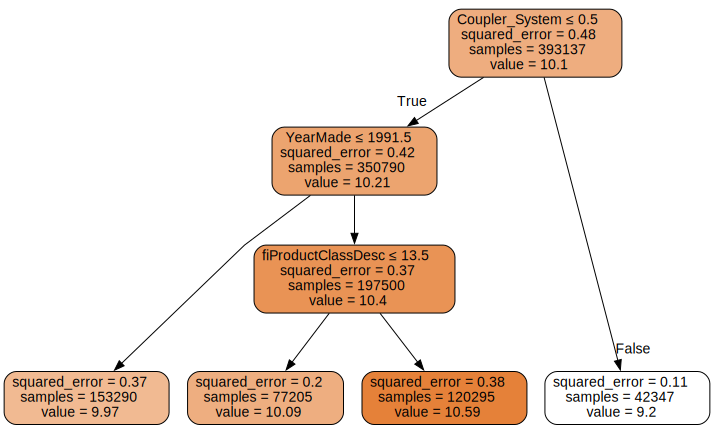

In [26]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [27]:
import dtreeviz

/home/kyan/mambaforge/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


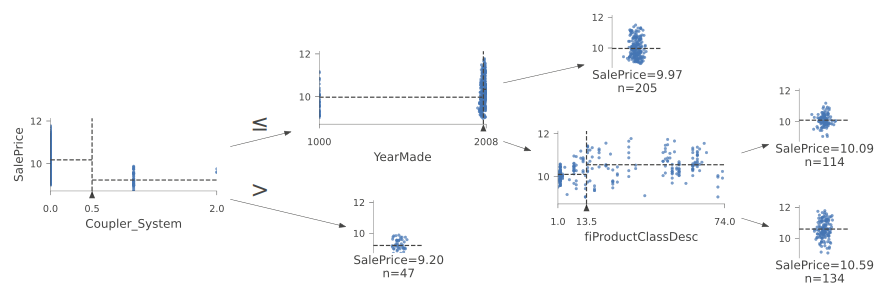

In [28]:
samp_idx = np.random.permutation(len(y))[:500]

viz = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names = xs.columns,target_name = dep_var)

# viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
# orientation='LR')
viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
orientation='LR')

In [29]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

/home/kyan/mambaforge/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


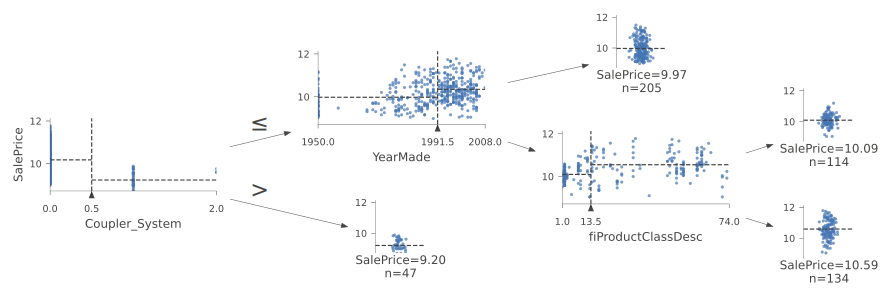

In [30]:
viz = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names = xs.columns,target_name = dep_var)

# viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
# orientation='LR')
viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
orientation='LR')

### Examples of overfitting:

In [31]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [32]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [33]:
m_rmse(m, xs, y)

0.0

In [34]:
m_rmse(m, valid_xs, valid_y)
#high validation loss

0.36593

In [ ]:
m.get_n_leaves(), len(xs)
#nearly as many leaf nodes as data points

This can be fixed by increasing the minimum samples per leaf:

In [36]:
m = DecisionTreeRegressor(min_samples_leaf = 25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.239682, 0.325518)

In [37]:
m.get_n_leaves()

12016

## Random Forest

In [38]:
# stacking lots of estimators together

def rf(xs, y, n_estimators=40, max_samples = 200_000, 
       max_features = 0.5, min_samples_leaf = 2, **kwargs):
    return RandomForestRegressor(n_jobs= -1, #building all the trees in parallel
                                 n_estimators= n_estimators, 
                                 max_samples = max_samples,
                                 max_features = max_features,
                                 min_samples_leaf = min_samples_leaf,
                                 oob_score = True).fit(xs,y)

In [41]:
m = rf(xs, y) # init model

m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.138878, 0.242879)

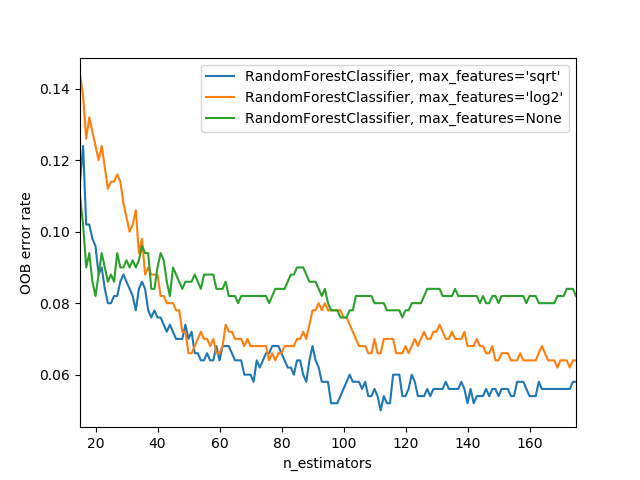

We would get a lower OOB error rate if we used less features.

In [44]:
# stacking lots of estimators together

def rf(xs, y, n_estimators=120, max_samples = 200_000, 
       max_features = 0.5, min_samples_leaf = 2, **kwargs):
    return RandomForestRegressor(n_jobs= -1, #building all the trees in parallel
                                 n_estimators= n_estimators, 
                                 max_samples = max_samples,
                                 max_features = 'sqrt',
                                 min_samples_leaf = min_samples_leaf,
                                 oob_score = True).fit(xs,y)

In [45]:
m = rf(xs, y) # init model

m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.165137, 0.260407)

Each estimator is stored in ```m.estimators_```

We can also use the OOB error as a way of measuring the prediction error on the subset of data that was not used in training. Recall that each random forest uses a subset of the features and a subset of the data. The validation set is simply the rows not selected in training

In [47]:
r_mse(m.oob_prediction_, y)

0.221214

## Model Interpretation

In [49]:
import warnings
warnings.filterwarnings("ignore")
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
# Getting a list of 

In [53]:
valid_xs.shape

(19561, 66)

In [50]:
preds.shape

(120, 19561)

In [55]:
# Given a list of predictions for each tree, we can measure the prediction confidence by looking at the standard deviation
preds_std = preds.std(0)

In [57]:
preds_std[:5] #confience varies wildly

array([0.36860677, 0.19534353, 0.15257393, 0.26319265, 0.24882683])

# Feature importances


In [60]:
# function that places feature importances into a dataframe
def rf_feature_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [61]:
fi = rf_feature_importances(m,xs)
fi[:10]

,cols,imp
57,YearMade,0.117120
6,ProductSize,0.076176
3,fiSecondaryDesc,0.065648
30,Coupler_System,0.055408
54,ModelID,0.053632
12,Enclosure,0.052975
7,fiProductClassDesc,0.048312
1,fiModelDesc,0.044835
5,fiModelDescriptor,0.036159
52,SalesID,0.034906


<Axes: ylabel='cols'>

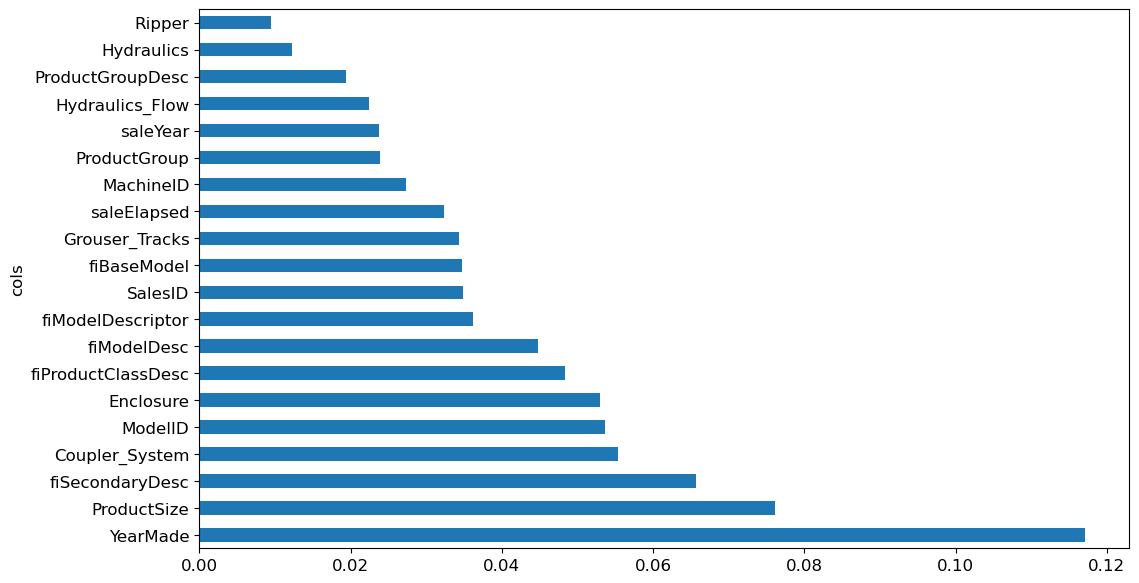

In [64]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize = (12,7), legend= False)
plot_fi(fi[:20])

In [75]:
# Removing Redundant Features
to_keep = fi[fi.imp > 0.01].cols
xs_imp = xs[to_keep]

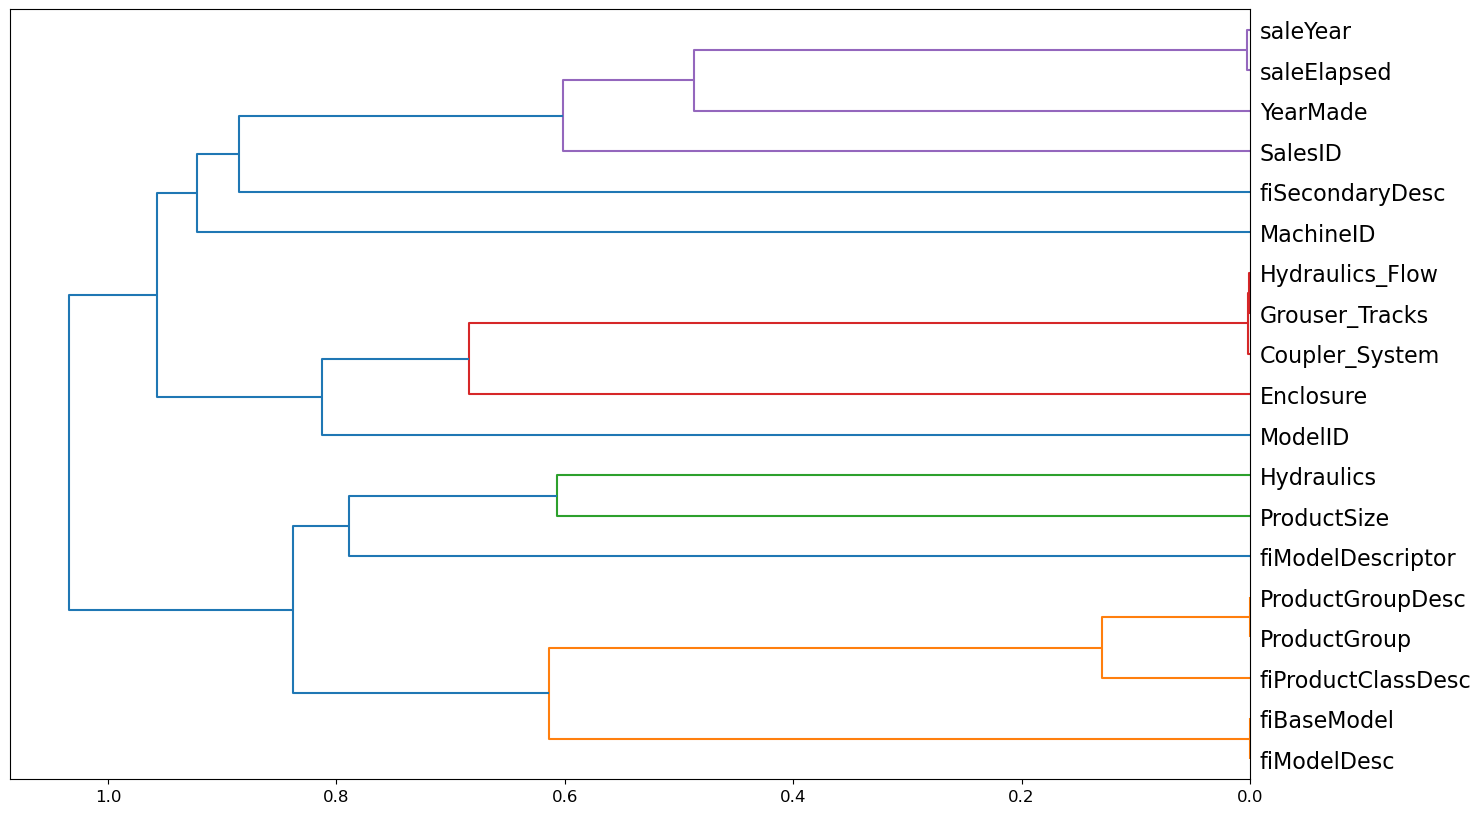

In [76]:
# Plotting dendrogram

from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(xs_imp).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize = (16,10))
dendrogram = hc.dendrogram(z, labels = xs_imp.columns, orientation = 'left', leaf_font_size = 16)
plt.show()

The most similar features are grouped early:
- Product group desc, etc and hydraulics

In [78]:
# Seeing if some closely related features can be removed without impacting accuracy.
# Helper function

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                              max_samples = 50000, max_features = 0.5, n_jobs = -1, oob_score = True)
    m.fit(df, y)
    return m.oob_score_

In [77]:
# Taken from https://forums.fast.ai/t/unofficial-lesson-4-classnotes/7569

In [79]:
# baseline
get_oob(xs_imp)

0.8745473164803944

In [80]:
{c: get_oob(xs_imp.drop(c, axis = 1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8744260351898279,
 'saleElapsed': 0.8701710480347755,
 'ProductGroupDesc': 0.8745761335708796,
 'ProductGroup': 0.8742828337171804,
 'fiModelDesc': 0.8741822477197271,
 'fiBaseModel': 0.8737282841334494,
 'Hydraulics_Flow': 0.8752400500158898,
 'Grouser_Tracks': 0.8753254474611961,
 'Coupler_System': 0.8752980876028608}

In [82]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks'] # dropping one from all pairwise fields
get_oob(xs_imp.drop(to_drop, axis=1))

0.8713497803016159

In [83]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

NameError: name 'valid_xs_imp' is not defined

## Partial Dependence Plots


In [ ]:
# Our two most important predictors are ProductSize and YearMade

<Axes: ylabel='ProductSize'>

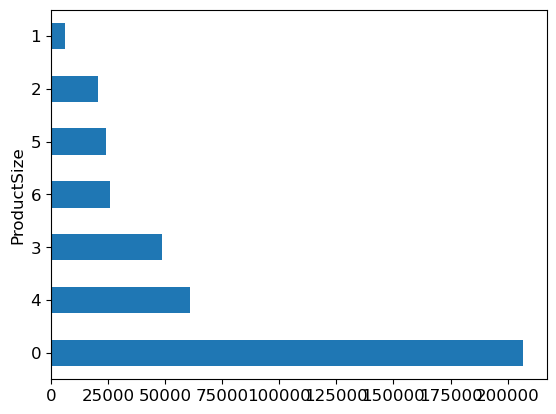

In [86]:
xs_imp['ProductSize'].value_counts().plot.barh()

<Axes: >

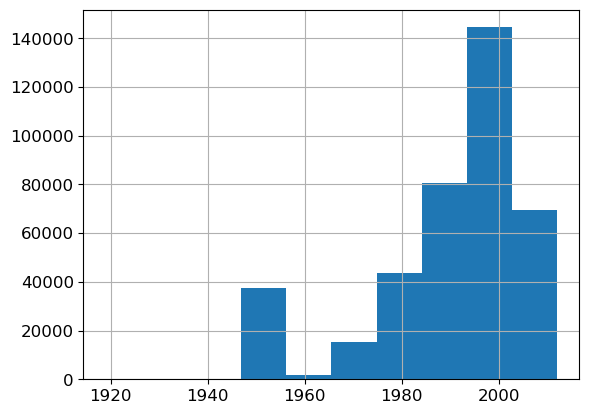

In [87]:
xs_imp['YearMade'].hist()

Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does YearMade impact sale price, all other things being equal?

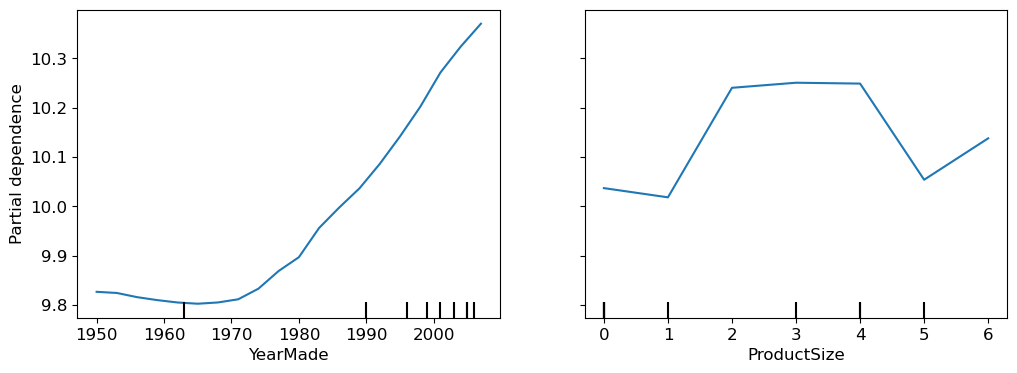

In [91]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);